In [1]:
import os
import tempfile
import shutil
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

from medmnist import ChestMNIST
from pytorch_fid import fid_score
from skimage.metrics import structural_similarity as ssim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

latent_dim = 100
embedding_dim = 10
num_classes = 2  # 0: non-pneumonia, 1: pneumonia
img_size = 64
img_channels = 1  # Grayscale images
batch_size = 64
num_epochs = 400    # Maximum number of epochs; you can extend this as needed
lr = 0.0004
step_size = 25     # Every 50 epochs, the LR will be decayed
gamma = 0.99        # Decay factor for LR

Using device: cuda


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.block(x)
        out += x  # Skip connection
        return self.relu(out)


In [4]:
class GeneratorIncreasedChannels(nn.Module):
    def __init__(self, latent_dim, embedding_dim, num_classes, img_channels, img_size):
        super(GeneratorIncreasedChannels, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        # Keep the same scaling factor: downsampled size will be img_size//4
        self.init_size = img_size // 4  
        # Increase the number of channels in the first fully connected layer to 256 instead of 128
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 256 * self.init_size * self.init_size)
        )
        
        # Initial upsampling block – now working with 256 channels
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),  # Upsample from init_size to init_size*2
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(inplace=True)
        )
        
        # Add a couple of Residual Blocks; these work on 256 channels
        self.residual_blocks = nn.Sequential(
            ResidualBlock(256)
        )
        
        # Final blocks: upsample and reduce channels to produce the final image
        self.final_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),  # Upsample to full image resolution
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Tanh activation yields outputs in [-1, 1]
        )
        
    def forward(self, noise, labels):
        # Embed the labels
        label_input = self.label_embedding(labels)
        # Concatenate noise and label embedding along the last dimension
        gen_input = torch.cat((noise, label_input), dim=-1)
        out = self.fc(gen_input)
        # Reshape to a feature map of shape (batch, 256, init_size, init_size)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        out = self.conv_blocks(out)
        out = self.residual_blocks(out)
        img = self.final_blocks(out)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, num_classes, img_size, embedding_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + 1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
        ds_size = img_size // 2**4  # after 4 downsampling steps
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img, labels):
        label_embedding = self.label_embedding(labels)
        # Expand label embedding to match image spatial size
        label_map = label_embedding.unsqueeze(2).unsqueeze(3)
        label_map = label_map.repeat(1, 1, img.size(2), img.size(3))
        label_map = label_map.mean(dim=1, keepdim=True)  # average to get one channel
        d_in = torch.cat((img, label_map), 1)
        out = self.model(d_in)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [6]:
generator = GeneratorIncreasedChannels(latent_dim, embedding_dim, num_classes, img_channels, img_size).to(device)
discriminator = Discriminator(img_channels, num_classes, img_size, embedding_dim).to(device)
print(generator)
print(discriminator)

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Learning rate schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=step_size, gamma=gamma)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=step_size, gamma=gamma)

GeneratorIncreasedChannels(
  (label_embedding): Embedding(2, 10)
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=65536, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, base_dataset, pneumonia_index=6):
        self.base_dataset = base_dataset
        self.indices = [i for i in range(len(self.base_dataset)) if int(self.base_dataset[i][1][pneumonia_index]) == 1]
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, _ = self.base_dataset[real_idx]
        # Convert image range from [0,1] to [-1,1] to match generator output (using Tanh)
        img = img * 2 - 1
        return img, 1  # pneumonia label is 1

transform = transforms.Compose([
    transforms.ToTensor()
])
full_train_dataset = ChestMNIST(split='train', download=True, transform=transform, size=img_size)
pneumonia_dataset = PneumoniaDataset(full_train_dataset, pneumonia_index=6)
pneumonia_loader = DataLoader(pneumonia_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def sample_real_images(loader, num_samples=100):
    imgs_list = []
    count = 0
    for imgs, _ in loader:
        imgs_list.append(imgs)
        count += imgs.size(0)
        if count >= num_samples:
            break
    imgs = torch.cat(imgs_list, dim=0)[:num_samples]
    imgs = (imgs + 1) / 2  # Convert from [-1,1] to [0,1]
    return imgs

fixed_real = sample_real_images(pneumonia_loader, num_samples=100)

In [ ]:
def save_images_to_folder(images, folder, prefix):
    os.makedirs(folder, exist_ok=True)
    for i in range(images.size(0)):
        img = images[i]
        save_path = os.path.join(folder, f"{prefix}_{i}.png")
        utils.save_image(img, save_path)

def compute_batch_ssim(real_imgs, fake_imgs):
    # Assume real_imgs and fake_imgs are numpy arrays of shape (N, 1, H, W)
    real_imgs = real_imgs.squeeze(1)
    fake_imgs = fake_imgs.squeeze(1)
    ssim_vals = []
    for i in range(real_imgs.shape[0]):
        s = ssim(real_imgs[i], fake_imgs[i], data_range=1.0)
        ssim_vals.append(s)
    return np.mean(ssim_vals)

In [ ]:
temp_real_dir = tempfile.mkdtemp()
temp_fake_dir = tempfile.mkdtemp()

In [97]:
best_fid = float('inf')
best_epoch = 0

print("Starting GAN training with Learning Rate Scheduler...")
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for i, (imgs, _) in enumerate(pneumonia_loader):
        current_batch = imgs.size(0)
        valid = torch.ones(current_batch, 1, device=device)
        fake_label = torch.zeros(current_batch, 1, device=device)
        
        real_imgs = imgs.to(device)
        labels = torch.ones(current_batch, dtype=torch.long, device=device)
        
        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(current_batch, latent_dim, device=device)
        gen_labels = torch.ones(current_batch, dtype=torch.long, device=device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()
        
        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake_label)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(pneumonia_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    # Step the schedulers
    scheduler_G.step()
    scheduler_D.step()
    
    # Evaluate after each epoch
    generator.eval()
    with torch.no_grad():
        z = torch.randn(100, latent_dim, device=device)
        gen_labels = torch.ones(100, dtype=torch.long, device=device)
        fake_imgs = generator(z, gen_labels)
    fake_imgs = (fake_imgs + 1) / 2  # Convert to [0,1]
    
    # Clear temporary directories
    for f in os.listdir(temp_real_dir):
        os.remove(os.path.join(temp_real_dir, f))
    for f in os.listdir(temp_fake_dir):
        os.remove(os.path.join(temp_fake_dir, f))
    save_images_to_folder(fixed_real, temp_real_dir, "real")
    save_images_to_folder(fake_imgs, temp_fake_dir, "fake")
    
    current_fid = fid_score.calculate_fid_given_paths([temp_real_dir, temp_fake_dir],
                                                       batch_size, device, dims=2048)
    fixed_real_np = fixed_real.cpu().numpy()
    fake_imgs_np = fake_imgs.cpu().numpy()
    current_ssim = compute_batch_ssim(fixed_real_np, fake_imgs_np)
    
    print(f"Epoch {epoch} -- FID: {current_fid:.3f}, SSIM: {current_ssim:.3f}")
    
    # Save best generator checkpoint based on FID (lower is better)
    if current_fid < best_fid:
        best_fid = current_fid
        best_epoch = epoch
        torch.save(generator.state_dict(), "best_rlrgenerator.pth")
        print(f"New best model found at epoch {epoch} with FID: {current_fid:.3f}")
    
print(f"Training complete. Best FID: {best_fid:.3f} at epoch {best_epoch}.")

100%|██████████| 2/2 [00:07<00:00,  3.61s/it]


Epoch 250 -- FID: 176.054, SSIM: 0.337
[Epoch 251/400] [Batch 0/16] [D loss: 0.4167] [G loss: 0.9581]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 251 -- FID: 167.905, SSIM: 0.317
[Epoch 252/400] [Batch 0/16] [D loss: 0.4017] [G loss: 1.3419]


100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


Epoch 252 -- FID: 158.143, SSIM: 0.328
[Epoch 253/400] [Batch 0/16] [D loss: 0.3913] [G loss: 2.0578]


100%|██████████| 2/2 [00:06<00:00,  3.27s/it]


Epoch 253 -- FID: 161.870, SSIM: 0.350
[Epoch 254/400] [Batch 0/16] [D loss: 0.4777] [G loss: 1.0628]


100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


Epoch 254 -- FID: 200.185, SSIM: 0.317
[Epoch 255/400] [Batch 0/16] [D loss: 0.4016] [G loss: 1.7014]


100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


Epoch 255 -- FID: 178.896, SSIM: 0.348
[Epoch 256/400] [Batch 0/16] [D loss: 0.5087] [G loss: 0.9722]


100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


Epoch 256 -- FID: 169.251, SSIM: 0.356
[Epoch 257/400] [Batch 0/16] [D loss: 0.4503] [G loss: 1.0530]


100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


Epoch 257 -- FID: 176.998, SSIM: 0.316
[Epoch 258/400] [Batch 0/16] [D loss: 0.4862] [G loss: 1.5263]


100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 258 -- FID: 203.044, SSIM: 0.318
[Epoch 259/400] [Batch 0/16] [D loss: 0.3921] [G loss: 1.9987]


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 259 -- FID: 151.172, SSIM: 0.326
New best model found at epoch 259 with FID: 151.172
[Epoch 260/400] [Batch 0/16] [D loss: 0.3747] [G loss: 1.4729]


100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


Epoch 260 -- FID: 200.093, SSIM: 0.349
[Epoch 261/400] [Batch 0/16] [D loss: 0.4518] [G loss: 1.7240]


100%|██████████| 2/2 [00:05<00:00,  2.98s/it]


Epoch 261 -- FID: 191.685, SSIM: 0.322
[Epoch 262/400] [Batch 0/16] [D loss: 0.3927] [G loss: 1.3461]


100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


Epoch 262 -- FID: 184.085, SSIM: 0.311
[Epoch 263/400] [Batch 0/16] [D loss: 0.4303] [G loss: 1.5547]


100%|██████████| 2/2 [00:05<00:00,  2.99s/it]


Epoch 263 -- FID: 176.044, SSIM: 0.333
[Epoch 264/400] [Batch 0/16] [D loss: 0.4893] [G loss: 1.5202]


100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 264 -- FID: 161.508, SSIM: 0.353
[Epoch 265/400] [Batch 0/16] [D loss: 0.4378] [G loss: 1.5916]


100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


Epoch 265 -- FID: 174.647, SSIM: 0.347
[Epoch 266/400] [Batch 0/16] [D loss: 0.4211] [G loss: 0.9262]


100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


Epoch 266 -- FID: 174.057, SSIM: 0.364
[Epoch 267/400] [Batch 0/16] [D loss: 0.4249] [G loss: 1.3396]


100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


Epoch 267 -- FID: 177.282, SSIM: 0.328
[Epoch 268/400] [Batch 0/16] [D loss: 0.4194] [G loss: 1.1612]


100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


Epoch 268 -- FID: 192.274, SSIM: 0.308
[Epoch 269/400] [Batch 0/16] [D loss: 0.6432] [G loss: 0.8593]


100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


Epoch 269 -- FID: 190.205, SSIM: 0.321
[Epoch 270/400] [Batch 0/16] [D loss: 0.4117] [G loss: 1.0713]


100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


Epoch 270 -- FID: 168.758, SSIM: 0.356
[Epoch 271/400] [Batch 0/16] [D loss: 0.5410] [G loss: 0.9948]


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


Epoch 271 -- FID: 182.276, SSIM: 0.306
[Epoch 272/400] [Batch 0/16] [D loss: 0.4214] [G loss: 1.2340]


100%|██████████| 2/2 [00:08<00:00,  4.39s/it]


Epoch 272 -- FID: 156.734, SSIM: 0.345
[Epoch 273/400] [Batch 0/16] [D loss: 0.3498] [G loss: 1.7403]


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Epoch 273 -- FID: 207.476, SSIM: 0.348
[Epoch 274/400] [Batch 0/16] [D loss: 0.3576] [G loss: 1.8511]


100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 274 -- FID: 205.100, SSIM: 0.337
[Epoch 275/400] [Batch 0/16] [D loss: 0.3497] [G loss: 2.0188]


100%|██████████| 2/2 [00:09<00:00,  4.63s/it]


Epoch 275 -- FID: 186.601, SSIM: 0.337
[Epoch 276/400] [Batch 0/16] [D loss: 0.3897] [G loss: 1.1473]


100%|██████████| 2/2 [00:07<00:00,  3.55s/it]


Epoch 276 -- FID: 171.035, SSIM: 0.350
[Epoch 277/400] [Batch 0/16] [D loss: 0.4295] [G loss: 1.5262]


100%|██████████| 2/2 [00:07<00:00,  3.55s/it]


Epoch 277 -- FID: 188.803, SSIM: 0.324
[Epoch 278/400] [Batch 0/16] [D loss: 0.3752] [G loss: 2.1551]


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


Epoch 278 -- FID: 187.531, SSIM: 0.309
[Epoch 279/400] [Batch 0/16] [D loss: 0.4559] [G loss: 1.4878]


100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch 279 -- FID: 165.197, SSIM: 0.329
[Epoch 280/400] [Batch 0/16] [D loss: 0.4881] [G loss: 1.3689]


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


Epoch 280 -- FID: 169.928, SSIM: 0.324
[Epoch 281/400] [Batch 0/16] [D loss: 0.4311] [G loss: 1.2982]


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


Epoch 281 -- FID: 166.768, SSIM: 0.349
[Epoch 282/400] [Batch 0/16] [D loss: 0.5872] [G loss: 1.3037]


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Epoch 282 -- FID: 172.667, SSIM: 0.338
[Epoch 283/400] [Batch 0/16] [D loss: 0.6596] [G loss: 0.9880]


100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


Epoch 283 -- FID: 173.208, SSIM: 0.332
[Epoch 284/400] [Batch 0/16] [D loss: 0.4604] [G loss: 1.2977]


100%|██████████| 2/2 [00:07<00:00,  3.62s/it]


Epoch 284 -- FID: 167.681, SSIM: 0.334
[Epoch 285/400] [Batch 0/16] [D loss: 0.6101] [G loss: 0.7708]


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 285 -- FID: 172.595, SSIM: 0.352
[Epoch 286/400] [Batch 0/16] [D loss: 0.2759] [G loss: 1.9438]


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 286 -- FID: 179.838, SSIM: 0.334
[Epoch 287/400] [Batch 0/16] [D loss: 0.4922] [G loss: 2.3382]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 287 -- FID: 172.568, SSIM: 0.343
[Epoch 288/400] [Batch 0/16] [D loss: 0.4787] [G loss: 1.2082]


100%|██████████| 2/2 [00:07<00:00,  3.57s/it]


Epoch 288 -- FID: 188.153, SSIM: 0.338
[Epoch 289/400] [Batch 0/16] [D loss: 0.2899] [G loss: 2.2901]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 289 -- FID: 165.667, SSIM: 0.332
[Epoch 290/400] [Batch 0/16] [D loss: 0.2238] [G loss: 4.2373]


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


Epoch 290 -- FID: 168.359, SSIM: 0.340
[Epoch 291/400] [Batch 0/16] [D loss: 0.4776] [G loss: 1.5019]


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 291 -- FID: 148.844, SSIM: 0.334
New best model found at epoch 291 with FID: 148.844
[Epoch 292/400] [Batch 0/16] [D loss: 0.5057] [G loss: 1.2404]


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 292 -- FID: 172.544, SSIM: 0.329
[Epoch 293/400] [Batch 0/16] [D loss: 0.4410] [G loss: 1.2032]


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 293 -- FID: 202.538, SSIM: 0.337
[Epoch 294/400] [Batch 0/16] [D loss: 0.4449] [G loss: 1.1644]


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Epoch 294 -- FID: 183.507, SSIM: 0.327
[Epoch 295/400] [Batch 0/16] [D loss: 0.6199] [G loss: 0.8365]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 295 -- FID: 166.124, SSIM: 0.347
[Epoch 296/400] [Batch 0/16] [D loss: 0.4277] [G loss: 1.6272]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 296 -- FID: 170.949, SSIM: 0.332
[Epoch 297/400] [Batch 0/16] [D loss: 0.4206] [G loss: 1.2619]


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 297 -- FID: 175.559, SSIM: 0.338
[Epoch 298/400] [Batch 0/16] [D loss: 0.2907] [G loss: 1.7150]


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 298 -- FID: 167.052, SSIM: 0.322
[Epoch 299/400] [Batch 0/16] [D loss: 0.3643] [G loss: 1.7443]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 299 -- FID: 184.288, SSIM: 0.338
[Epoch 300/400] [Batch 0/16] [D loss: 0.5328] [G loss: 1.1486]


100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


Epoch 300 -- FID: 195.151, SSIM: 0.341
[Epoch 301/400] [Batch 0/16] [D loss: 0.4329] [G loss: 1.7744]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 301 -- FID: 181.875, SSIM: 0.325
[Epoch 302/400] [Batch 0/16] [D loss: 0.5097] [G loss: 1.2943]


100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


Epoch 302 -- FID: 168.395, SSIM: 0.332
[Epoch 303/400] [Batch 0/16] [D loss: 0.2931] [G loss: 1.3793]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 303 -- FID: 181.082, SSIM: 0.327
[Epoch 304/400] [Batch 0/16] [D loss: 0.5617] [G loss: 0.7686]


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 304 -- FID: 178.118, SSIM: 0.308
[Epoch 305/400] [Batch 0/16] [D loss: 0.4884] [G loss: 1.1075]


100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


Epoch 305 -- FID: 182.574, SSIM: 0.343
[Epoch 306/400] [Batch 0/16] [D loss: 0.3374] [G loss: 1.7137]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 306 -- FID: 189.485, SSIM: 0.349
[Epoch 307/400] [Batch 0/16] [D loss: 0.3148] [G loss: 1.6697]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 307 -- FID: 168.924, SSIM: 0.342
[Epoch 308/400] [Batch 0/16] [D loss: 0.3921] [G loss: 2.1534]


100%|██████████| 2/2 [00:07<00:00,  3.59s/it]


Epoch 308 -- FID: 155.894, SSIM: 0.322
[Epoch 309/400] [Batch 0/16] [D loss: 0.2749] [G loss: 2.2383]


100%|██████████| 2/2 [00:07<00:00,  3.57s/it]


Epoch 309 -- FID: 177.299, SSIM: 0.335
[Epoch 310/400] [Batch 0/16] [D loss: 0.3442] [G loss: 1.6815]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 310 -- FID: 177.409, SSIM: 0.333
[Epoch 311/400] [Batch 0/16] [D loss: 0.2493] [G loss: 2.2381]


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 311 -- FID: 152.850, SSIM: 0.334
[Epoch 312/400] [Batch 0/16] [D loss: 0.3531] [G loss: 1.4907]


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 312 -- FID: 169.138, SSIM: 0.311
[Epoch 313/400] [Batch 0/16] [D loss: 0.5393] [G loss: 1.1794]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 313 -- FID: 151.256, SSIM: 0.336
[Epoch 314/400] [Batch 0/16] [D loss: 0.6018] [G loss: 3.2929]


100%|██████████| 2/2 [00:07<00:00,  3.68s/it]


Epoch 314 -- FID: 174.354, SSIM: 0.325
[Epoch 315/400] [Batch 0/16] [D loss: 0.3723] [G loss: 1.2315]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 315 -- FID: 150.764, SSIM: 0.333
[Epoch 316/400] [Batch 0/16] [D loss: 0.3995] [G loss: 2.7447]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 316 -- FID: 191.340, SSIM: 0.318
[Epoch 317/400] [Batch 0/16] [D loss: 0.4838] [G loss: 1.2796]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 317 -- FID: 165.387, SSIM: 0.329
[Epoch 318/400] [Batch 0/16] [D loss: 0.3196] [G loss: 2.2576]


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Epoch 318 -- FID: 176.428, SSIM: 0.332
[Epoch 319/400] [Batch 0/16] [D loss: 0.3273] [G loss: 1.7450]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 319 -- FID: 184.724, SSIM: 0.336
[Epoch 320/400] [Batch 0/16] [D loss: 0.3585] [G loss: 1.5955]


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Epoch 320 -- FID: 170.786, SSIM: 0.344
[Epoch 321/400] [Batch 0/16] [D loss: 0.4595] [G loss: 1.7454]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 321 -- FID: 173.776, SSIM: 0.337
[Epoch 322/400] [Batch 0/16] [D loss: 0.3169] [G loss: 1.5889]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 322 -- FID: 176.055, SSIM: 0.334
[Epoch 323/400] [Batch 0/16] [D loss: 0.2779] [G loss: 1.9180]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 323 -- FID: 153.758, SSIM: 0.338
[Epoch 324/400] [Batch 0/16] [D loss: 0.3548] [G loss: 2.0721]


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Epoch 324 -- FID: 154.186, SSIM: 0.333
[Epoch 325/400] [Batch 0/16] [D loss: 0.3640] [G loss: 2.0160]


100%|██████████| 2/2 [00:07<00:00,  3.61s/it]


Epoch 325 -- FID: 166.830, SSIM: 0.336
[Epoch 326/400] [Batch 0/16] [D loss: 0.2926] [G loss: 2.5900]


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 326 -- FID: 157.350, SSIM: 0.335
[Epoch 327/400] [Batch 0/16] [D loss: 0.3656] [G loss: 3.1827]


100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


Epoch 327 -- FID: 167.363, SSIM: 0.333
[Epoch 328/400] [Batch 0/16] [D loss: 0.4621] [G loss: 1.6462]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 328 -- FID: 179.700, SSIM: 0.360
[Epoch 329/400] [Batch 0/16] [D loss: 0.2135] [G loss: 2.2029]


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 329 -- FID: 195.892, SSIM: 0.337
[Epoch 330/400] [Batch 0/16] [D loss: 0.4111] [G loss: 1.8830]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 330 -- FID: 172.163, SSIM: 0.335
[Epoch 331/400] [Batch 0/16] [D loss: 0.4590] [G loss: 1.3949]


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


Epoch 331 -- FID: 170.801, SSIM: 0.343
[Epoch 332/400] [Batch 0/16] [D loss: 0.3717] [G loss: 2.0638]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 332 -- FID: 195.477, SSIM: 0.341
[Epoch 333/400] [Batch 0/16] [D loss: 0.3500] [G loss: 1.3387]


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


Epoch 333 -- FID: 201.118, SSIM: 0.317
[Epoch 334/400] [Batch 0/16] [D loss: 0.3391] [G loss: 2.1545]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 334 -- FID: 137.662, SSIM: 0.359
New best model found at epoch 334 with FID: 137.662
[Epoch 335/400] [Batch 0/16] [D loss: 0.3402] [G loss: 2.2473]


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


Epoch 335 -- FID: 180.817, SSIM: 0.335
[Epoch 336/400] [Batch 0/16] [D loss: 0.4148] [G loss: 1.3141]


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Epoch 336 -- FID: 172.706, SSIM: 0.326
[Epoch 337/400] [Batch 0/16] [D loss: 0.3718] [G loss: 1.2375]


100%|██████████| 2/2 [00:07<00:00,  3.55s/it]


Epoch 337 -- FID: 165.544, SSIM: 0.330
[Epoch 338/400] [Batch 0/16] [D loss: 0.3467] [G loss: 1.5999]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 338 -- FID: 204.968, SSIM: 0.325
[Epoch 339/400] [Batch 0/16] [D loss: 0.4601] [G loss: 1.3795]


100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


Epoch 339 -- FID: 147.671, SSIM: 0.322
[Epoch 340/400] [Batch 0/16] [D loss: 0.2429] [G loss: 1.7835]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 340 -- FID: 169.819, SSIM: 0.327
[Epoch 341/400] [Batch 0/16] [D loss: 0.5855] [G loss: 3.1315]


100%|██████████| 2/2 [00:07<00:00,  3.66s/it]


Epoch 341 -- FID: 180.304, SSIM: 0.346
[Epoch 342/400] [Batch 0/16] [D loss: 0.3230] [G loss: 2.0950]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 342 -- FID: 145.976, SSIM: 0.336
[Epoch 343/400] [Batch 0/16] [D loss: 0.2952] [G loss: 1.7402]


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Epoch 343 -- FID: 172.093, SSIM: 0.351
[Epoch 344/400] [Batch 0/16] [D loss: 0.2730] [G loss: 2.4958]


100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


Epoch 344 -- FID: 184.655, SSIM: 0.353
[Epoch 345/400] [Batch 0/16] [D loss: 0.4049] [G loss: 1.8511]


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


Epoch 345 -- FID: 188.917, SSIM: 0.322
[Epoch 346/400] [Batch 0/16] [D loss: 0.3269] [G loss: 1.4115]


100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


Epoch 346 -- FID: 181.829, SSIM: 0.337
[Epoch 347/400] [Batch 0/16] [D loss: 0.2683] [G loss: 1.7587]


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Epoch 347 -- FID: 167.460, SSIM: 0.339
[Epoch 348/400] [Batch 0/16] [D loss: 0.4280] [G loss: 1.2010]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 348 -- FID: 139.090, SSIM: 0.344
[Epoch 349/400] [Batch 0/16] [D loss: 0.3698] [G loss: 1.3825]


100%|██████████| 2/2 [00:07<00:00,  3.55s/it]


Epoch 349 -- FID: 154.986, SSIM: 0.344
[Epoch 350/400] [Batch 0/16] [D loss: 0.2882] [G loss: 2.2169]


100%|██████████| 2/2 [00:07<00:00,  3.63s/it]


Epoch 350 -- FID: 149.050, SSIM: 0.331
[Epoch 351/400] [Batch 0/16] [D loss: 0.3212] [G loss: 1.8347]


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 351 -- FID: 151.147, SSIM: 0.350
[Epoch 352/400] [Batch 0/16] [D loss: 0.4056] [G loss: 1.6796]


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Epoch 352 -- FID: 198.214, SSIM: 0.323
[Epoch 353/400] [Batch 0/16] [D loss: 0.5568] [G loss: 1.4523]


100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


Epoch 353 -- FID: 164.037, SSIM: 0.342
[Epoch 354/400] [Batch 0/16] [D loss: 0.4388] [G loss: 1.8655]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 354 -- FID: 169.564, SSIM: 0.315
[Epoch 355/400] [Batch 0/16] [D loss: 0.2635] [G loss: 1.7327]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 355 -- FID: 148.147, SSIM: 0.347
[Epoch 356/400] [Batch 0/16] [D loss: 0.4489] [G loss: 1.1240]


100%|██████████| 2/2 [00:07<00:00,  3.64s/it]


Epoch 356 -- FID: 157.107, SSIM: 0.339
[Epoch 357/400] [Batch 0/16] [D loss: 0.5724] [G loss: 1.4344]


100%|██████████| 2/2 [00:07<00:00,  3.63s/it]


Epoch 357 -- FID: 165.121, SSIM: 0.350
[Epoch 358/400] [Batch 0/16] [D loss: 0.5191] [G loss: 1.6830]


100%|██████████| 2/2 [00:07<00:00,  3.62s/it]


Epoch 358 -- FID: 137.832, SSIM: 0.315
[Epoch 359/400] [Batch 0/16] [D loss: 0.3498] [G loss: 2.1416]


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Epoch 359 -- FID: 171.870, SSIM: 0.330
[Epoch 360/400] [Batch 0/16] [D loss: 0.2489] [G loss: 2.0182]


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Epoch 360 -- FID: 169.701, SSIM: 0.322
[Epoch 361/400] [Batch 0/16] [D loss: 0.2420] [G loss: 2.0223]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 361 -- FID: 161.086, SSIM: 0.313
[Epoch 362/400] [Batch 0/16] [D loss: 0.1801] [G loss: 3.0529]


100%|██████████| 2/2 [00:07<00:00,  3.57s/it]


Epoch 362 -- FID: 181.742, SSIM: 0.343
[Epoch 363/400] [Batch 0/16] [D loss: 0.5269] [G loss: 1.3769]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 363 -- FID: 153.382, SSIM: 0.315
[Epoch 364/400] [Batch 0/16] [D loss: 0.4133] [G loss: 2.7007]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 364 -- FID: 182.421, SSIM: 0.321
[Epoch 365/400] [Batch 0/16] [D loss: 0.1908] [G loss: 2.2555]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 365 -- FID: 181.527, SSIM: 0.333
[Epoch 366/400] [Batch 0/16] [D loss: 0.4524] [G loss: 1.2892]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 366 -- FID: 185.844, SSIM: 0.319
[Epoch 367/400] [Batch 0/16] [D loss: 0.3679] [G loss: 2.3465]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 367 -- FID: 170.927, SSIM: 0.331
[Epoch 368/400] [Batch 0/16] [D loss: 0.3959] [G loss: 1.3681]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 368 -- FID: 175.442, SSIM: 0.321
[Epoch 369/400] [Batch 0/16] [D loss: 0.4293] [G loss: 1.9209]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 369 -- FID: 150.469, SSIM: 0.341
[Epoch 370/400] [Batch 0/16] [D loss: 0.3597] [G loss: 2.7586]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 370 -- FID: 153.892, SSIM: 0.334
[Epoch 371/400] [Batch 0/16] [D loss: 0.4083] [G loss: 1.7604]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 371 -- FID: 174.211, SSIM: 0.329
[Epoch 372/400] [Batch 0/16] [D loss: 0.3291] [G loss: 3.0335]


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 372 -- FID: 141.978, SSIM: 0.315
[Epoch 373/400] [Batch 0/16] [D loss: 0.4717] [G loss: 3.1737]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 373 -- FID: 168.142, SSIM: 0.323
[Epoch 374/400] [Batch 0/16] [D loss: 0.2667] [G loss: 1.9977]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 374 -- FID: 169.781, SSIM: 0.348
[Epoch 375/400] [Batch 0/16] [D loss: 0.3095] [G loss: 1.4760]


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 375 -- FID: 159.898, SSIM: 0.333
[Epoch 376/400] [Batch 0/16] [D loss: 0.2995] [G loss: 2.0262]


100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


Epoch 376 -- FID: 169.922, SSIM: 0.335
[Epoch 377/400] [Batch 0/16] [D loss: 0.4200] [G loss: 1.5160]


100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


Epoch 377 -- FID: 150.790, SSIM: 0.331
[Epoch 378/400] [Batch 0/16] [D loss: 0.2366] [G loss: 2.2051]


100%|██████████| 2/2 [00:07<00:00,  3.65s/it]


Epoch 378 -- FID: 165.304, SSIM: 0.326
[Epoch 379/400] [Batch 0/16] [D loss: 0.2542] [G loss: 1.9040]


100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


Epoch 379 -- FID: 173.544, SSIM: 0.344
[Epoch 380/400] [Batch 0/16] [D loss: 0.2027] [G loss: 2.2460]


100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


Epoch 380 -- FID: 165.554, SSIM: 0.320
[Epoch 381/400] [Batch 0/16] [D loss: 0.3118] [G loss: 2.2691]


100%|██████████| 2/2 [00:07<00:00,  3.64s/it]


Epoch 381 -- FID: 162.314, SSIM: 0.353
[Epoch 382/400] [Batch 0/16] [D loss: 0.2720] [G loss: 2.5250]


100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch 382 -- FID: 183.212, SSIM: 0.341
[Epoch 383/400] [Batch 0/16] [D loss: 0.3625] [G loss: 2.9115]


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


Epoch 383 -- FID: 169.228, SSIM: 0.316
[Epoch 384/400] [Batch 0/16] [D loss: 0.3091] [G loss: 2.4287]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 384 -- FID: 156.699, SSIM: 0.334
[Epoch 385/400] [Batch 0/16] [D loss: 0.2614] [G loss: 2.4767]


100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


Epoch 385 -- FID: 171.808, SSIM: 0.330
[Epoch 386/400] [Batch 0/16] [D loss: 0.3431] [G loss: 1.6591]


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 386 -- FID: 171.318, SSIM: 0.330
[Epoch 387/400] [Batch 0/16] [D loss: 0.4342] [G loss: 2.8776]


100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


Epoch 387 -- FID: 143.185, SSIM: 0.341
[Epoch 388/400] [Batch 0/16] [D loss: 0.3588] [G loss: 1.8925]


100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


Epoch 388 -- FID: 141.318, SSIM: 0.337
[Epoch 389/400] [Batch 0/16] [D loss: 0.3527] [G loss: 2.4683]


100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


Epoch 389 -- FID: 187.023, SSIM: 0.353
[Epoch 390/400] [Batch 0/16] [D loss: 0.2015] [G loss: 1.9491]


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 390 -- FID: 186.331, SSIM: 0.336
[Epoch 391/400] [Batch 0/16] [D loss: 0.4290] [G loss: 1.7796]


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


Epoch 391 -- FID: 175.346, SSIM: 0.321
[Epoch 392/400] [Batch 0/16] [D loss: 0.2673] [G loss: 1.8573]


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Epoch 392 -- FID: 162.465, SSIM: 0.335
[Epoch 393/400] [Batch 0/16] [D loss: 0.3828] [G loss: 1.5982]


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


Epoch 393 -- FID: 166.516, SSIM: 0.328
[Epoch 394/400] [Batch 0/16] [D loss: 0.1614] [G loss: 2.4687]


100%|██████████| 2/2 [00:07<00:00,  3.62s/it]


Epoch 394 -- FID: 168.747, SSIM: 0.354
[Epoch 395/400] [Batch 0/16] [D loss: 0.3233] [G loss: 1.7000]


100%|██████████| 2/2 [00:07<00:00,  3.59s/it]


Epoch 395 -- FID: 180.575, SSIM: 0.319
[Epoch 396/400] [Batch 0/16] [D loss: 0.2298] [G loss: 3.2283]


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Epoch 396 -- FID: 163.678, SSIM: 0.317
[Epoch 397/400] [Batch 0/16] [D loss: 0.3245] [G loss: 1.9994]


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Epoch 397 -- FID: 157.838, SSIM: 0.321
[Epoch 398/400] [Batch 0/16] [D loss: 0.4481] [G loss: 1.2784]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 398 -- FID: 162.608, SSIM: 0.359
[Epoch 399/400] [Batch 0/16] [D loss: 0.2450] [G loss: 2.9913]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 399 -- FID: 161.659, SSIM: 0.358
Training complete. Best FID: 137.662 at epoch 334.


In [98]:
print(f"Training complete. Best FID: {best_fid:.3f} at epoch {best_epoch}.")

Training complete. Best FID: 137.662 at epoch 334.


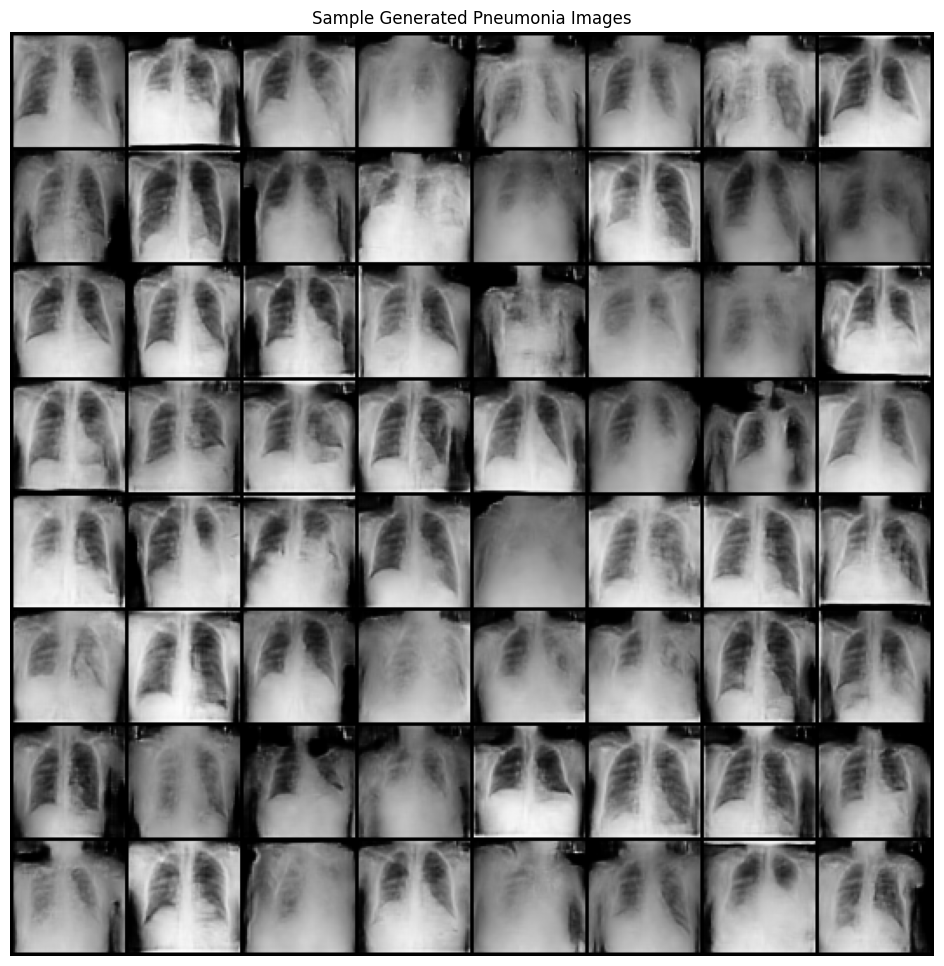

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

generator.load_state_dict(torch.load("best_rlrgenerator.pth", map_location=device))
generator.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    gen_labels = torch.ones(64, dtype=torch.long, device=device)  # Condition on pneumonia
    gen_imgs = generator(z, gen_labels)
    
# Convert images from [-1,1] to [0,1]
gen_imgs = (gen_imgs + 1) / 2
grid = make_grid(gen_imgs, nrow=8, padding=2, normalize=True)
np_grid = grid.cpu().numpy()
np_grid = np.transpose(np_grid, (1, 2, 0))

plt.figure(figsize=(12, 12))
plt.imshow(np_grid)
plt.title("Sample Generated Pneumonia Images")
plt.axis("off")
plt.show()